In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from skforecast.direct import ForecasterDirect

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from skforecast.preprocessing import RollingFeatures
from lightgbm import LGBMRegressor
# from astral.sun import sun
# from astral import LocationInfo
from skforecast.datasets import fetch_dataset
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from feature_engine.timeseries.forecasting import WindowFeatures

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.plot import plot_residuals, calculate_lag_autocorrelation
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

# ==============================================================================
import xgboost
import lightgbm
#import catboost
import sklearn
import shap
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
#from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    FunctionTransformer,
    PolynomialFeatures,
)
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

import skforecast
from skforecast.recursive import ForecasterEquivalentDate, ForecasterRecursive
from skforecast.model_selection import (
    TimeSeriesFold,
    OneStepAheadFold,
    bayesian_search_forecaster,
    backtesting_forecaster,
)
from skforecast.preprocessing import RollingFeatures
from skforecast.feature_selection import select_features
from skforecast.metrics import calculate_coverage


from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

from skforecast.recursive import ForecasterRecursive
from lightgbm import LGBMRegressor
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures


import warnings
warnings.filterwarnings('ignore')

In [91]:
# ==============================================================================
# DATA LOADING AND PREPROCESSING
# ==============================================================================

def load_and_prepare_data(
    file_path: str,
    date_column: str = 'date',
    target_column: str = 'price',
    cutoff_date: str = None,
    train_cutoff_date: str = '2025-10-31',
    freq: str = 'D'
):
    """
    Load and prepare time series data for forecasting.
    
    Parameters
    ----------
    file_path : str
        Path to CSV file
    date_column : str
        Name of date column
    target_column : str
        Name of target variable column
    cutoff_date : str, optional
        Maximum date to include in dataset
    train_cutoff_date : str
        Date to split training and out-of-sample data
    freq : str
        Frequency for time series (default: 'D' for daily)
    
    Returns
    -------
    dict with keys:
        - 'full_data': DataFrame with all data
        - 'train_data': DataFrame for training
        - 'out_of_sample': DataFrame for out-of-sample testing
        - 'y': Series of target variable indexed by date
        - 'data': DataFrame indexed by date
    """
    # Load data
    df = pd.read_csv(file_path)
    
    # Apply cutoff if specified
    if cutoff_date:
        df = df[df[date_column] <= cutoff_date].copy()
    
    # Convert to datetime
    df[date_column] = pd.to_datetime(df[date_column])
    
    # Split into training and out-of-sample
    train_cutoff = pd.Timestamp(train_cutoff_date)
    train_df = df[df[date_column] <= train_cutoff].copy()
    out_of_sample_df = df[df[date_column] > train_cutoff].copy()
    
    # Set index for training data
    train_df = train_df.set_index(date_column)
    train_df = train_df.asfreq(freq)
    
    # Extract target variable
    y = train_df[target_column].copy()
    data = train_df.copy()
    
    print(f"Training data: {len(train_df)} rows, from {train_df.index.min()} to {train_df.index.max()}")
    print(f"Out-of-sample data: {len(out_of_sample_df)} rows, from {out_of_sample_df[date_column].min()} to {out_of_sample_df[date_column].max()}")
    
    return {
        'full_data': df,
        'train_data': train_df,
        'out_of_sample': out_of_sample_df,
        'y': y,
        'data': data
    }

# Load data
data_dict = load_and_prepare_data(
    file_path='/home/mussie/Downloads/portfolio_collection/commodity_price_forcasting/df_clean_red_onion_a.csv',
    cutoff_date="2025-11-27 00:00:00+00:00",
    train_cutoff_date='2025-10-31'
)

df = data_dict['full_data']
train_df = data_dict['train_data']
out_of_sample_df = data_dict['out_of_sample']
data = data_dict['data']

Training data: 530 rows, from 2024-05-20 00:00:00 to 2025-10-31 00:00:00
Out-of-sample data: 27 rows, from 2025-11-01 00:00:00 to 2025-11-27 00:00:00


In [5]:
# Correct split dates
end_train = '2025-08-01 00:00:00'
end_validation = '2025-09-30 00:00:00'

# Split
data_train = data.loc[: end_train]
data_val   = data.loc[end_train : end_validation]
data_test  = data.loc[end_validation : ]

data = data.asfreq('D')


In [93]:
print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2024-05-20 00:00:00 --- 2025-08-01 00:00:00  (n=439)
Dates validacion : 2025-08-01 00:00:00 --- 2025-09-30 00:00:00  (n=61)
Dates test       : 2025-09-30 00:00:00 --- 2025-10-31 00:00:00  (n=32)


### broken down versions

In [94]:
FORECAST_HORIZON = 30

end_train = pd.to_datetime('2025-08-01')
end_val   = pd.to_datetime('2025-09-30')

y = data['price'].asfreq('D')


In [95]:
def make_calendar_features(df_index):
    df = pd.DataFrame(index=df_index)
    df["year"]        = df_index.year
    df["month"]       = df_index.month
    df["week"]        = df_index.isocalendar().week.astype(int)
    df["day_of_week"] = df_index.dayofweek
    df["day_of_year"] = df_index.dayofyear
    return df


In [96]:
def add_cyclical_features(df):
    
    cyc = CyclicalFeatures(
        variables=['month','week','day_of_week'],
        max_values={'month': 12, 'week': 52, 'day_of_week': 7},
        drop_original=False
    )
    return cyc.fit_transform(df), cyc


In [97]:
def make_weekend_month_features(idx):
    df = pd.DataFrame(index=idx)
    df["is_weekend"] = (idx.dayofweek >= 5).astype(int)
    df["is_day_before_weekend"] = (idx.dayofweek == 4).astype(int)
    df["is_day_after_weekend"]  = (idx.dayofweek == 0).astype(int)
    df["day_of_month"] = idx.day
    df["month_position"] = np.sin(2 * np.pi * idx.day / 30.0)
    return df


In [98]:
def ethiopian_holidays_for_year(year):
    """
    Returns the main Ethiopian holidays for a given year.
    """
    return {
        "ethiopian_christmas": f"{year}-01-07",
        "timkat":              f"{year}-01-19",
        "meskel":              f"{year}-09-27",
        "ethiopian_new_year":  f"{year}-09-11"
    }



In [99]:
def make_multi_year_holiday_windows(idx, window=4):
    """
    Generate holiday indicators and ±window day features for ALL years in index.
    """
    years = range(idx.min().year, idx.max().year + 1)

    holiday_df = pd.DataFrame(index=idx)

    for year in years:
        holidays = ethiopian_holidays_for_year(year)

        for name, date_str in holidays.items():
            hday = pd.to_datetime(date_str)

            # Exact holiday
            holiday_df[f"{name}_{year}"] = (idx == hday).astype(int)

            # Pre/Post windows
            for k in range(1, window + 1):
                holiday_df[f"{name}_{year}_pre_{k}"]  = (idx == (hday - pd.Timedelta(days=k))).astype(int)
                holiday_df[f"{name}_{year}_post_{k}"] = (idx == (hday + pd.Timedelta(days=k))).astype(int)

    return holiday_df


In [100]:
def get_holiday_list(idx):
    """
    Return a list of all Ethiopian holiday dates across all years in index.
    """
    years = range(idx.min().year, idx.max().year + 1)
    hlist = []

    for year in years:
        holidays = ethiopian_holidays_for_year(year)
        for ds in holidays.values():
            hlist.append(pd.to_datetime(ds))

    return sorted(hlist)


In [101]:
def nearest_holiday_distance(idx):
    """
    For each date, find distance to nearest Ethiopian holiday.
    """
    holiday_list = get_holiday_list(idx)
    out = []

    for d in idx:
        diffs = [(d - h).days for h in holiday_list]
        out.append(min(diffs, key=lambda x: abs(x)))

    return out


In [102]:
def make_holiday_distance_features(idx):
    dist = np.array(nearest_holiday_distance(idx))

    df = pd.DataFrame(index=idx)
    df["holiday_distance"] = dist
    # df["days_since_last_holiday"]  = np.clip(dist, 0, None)
    # df["days_until_next_holiday"]  = np.clip(-dist, 0, None)
    df["holiday_distance_sin"] = np.sin(dist / 7)
    df["holiday_distance_cos"] = np.cos(dist / 7)

    return df


In [103]:
def make_rolling_features(y):
    df = pd.DataFrame(index=y.index)
    df['roll7']   = y.shift(1).rolling(7).mean()
    df['roll14']  = y.shift(1).rolling(14).mean()
    df['roll30']  = y.shift(1).rolling(30).mean()
    df['y_roll90']  = y.shift(1).rolling(90).mean()
    df['y_roll180']  = y.shift(1).rolling(180).mean()

    return df


In [104]:
def make_diff_features(y):
    df = pd.DataFrame(index=y.index)

    df["y_diff1"]  = y.diff(1)
    df["y_diff7"]  = y.diff(7)
    df["y_diff14"] = y.diff(14)
    df["y_diff30"] = y.diff(30)
    df["y_diff60"] = y.diff(60)
    df["y_diff90"] = y.diff(90)
    return df


In [105]:
def make_volatility(y):
    df = pd.DataFrame(index=y.index)
    df["y_vol7"]  = y.shift(1).rolling(7).std()
    df["y_vol14"] = y.shift(1).rolling(14).std()
    df["y_vol30"] = y.shift(1).rolling(30).std()
    return df


In [106]:
def make_momentum(y):
    df = pd.DataFrame(index=y.index)
    df["momentum7"]  = (y.shift(1) - y.shift(7)) / y.shift(7)
    df["momentum14"] = (y.shift(1) - y.shift(14)) / y.shift(14)
    df["momentum30"] = (y.shift(1) - y.shift(30)) / y.shift(30)
    return df


In [107]:
def rolling_slope(series, window):
    arr = series.values
    slopes = [np.nan] * len(arr)
    x = np.arange(window)
    for i in range(window, len(arr)):
        y_win = arr[i-window:i]
        if np.isnan(y_win).any():
            slopes[i] = np.nan
        else:
            slopes[i] = np.polyfit(x, y_win, 1)[0]
    return slopes


def make_trend_slopes(y):
    df = pd.DataFrame(index=y.index)
    df["trend_slope_7"]  = rolling_slope(y.shift(1), 7)
    df["trend_slope_30"] = rolling_slope(y.shift(1), 30)
    df["trend_slope_60"] = rolling_slope(y.shift(1), 60)
    df["trend_slope_90"] = rolling_slope(y.shift(1), 90)
    df["trend_slope_180"] = rolling_slope(y.shift(1), 180)
    return df


In [108]:
# def make_fourier(index, period, K):
#     t = np.arange(len(index))
#     df = pd.DataFrame(index=index)
#     for k in range(1, K+1):
#         df[f'sin_{period}_{k}'] = np.sin(2*np.pi*k*t/period)
#         df[f'cos_{period}_{k}'] = np.cos(2*np.pi*k*t/period)
#     return df


# def fourier_features(idx):
#     return pd.concat([
#         make_fourier(idx, 7, 3),
#         make_fourier(idx, 365, 5)
#     ], axis=1)

def make_fourier(index, period, K, time_unit='days'):
    """
    Generate Fourier terms for seasonal modeling.
    
    Parameters
    ----------
    index : pd.DatetimeIndex
    period : float (e.g., 7 for weekly, 365.25 for annual)
    K : int, number of harmonics (1 ≤ K ≤ period//2)
    time_unit : 'days' (default) or 'seconds'
    
    Returns
    -------
    pd.DataFrame with 2*K columns: sin_p_k, cos_p_k
    """
    if not isinstance(index, pd.DatetimeIndex):
        index = pd.to_datetime(index)
    
    # Use true elapsed time (robust to missing days)
    if time_unit == 'days':
        t = (index - index[0]).days
    elif time_unit == 'seconds':
        t = (index - index[0]).total_seconds()
    else:
        raise ValueError("time_unit must be 'days' or 'seconds'")
    
    df = pd.DataFrame(index=index)
    for k in range(1, K + 1):
        angle = 2 * np.pi * k * t / period
        df[f'sin_{int(period)}_{k}'] = np.sin(angle)
        df[f'cos_{int(period)}_{k}'] = np.cos(angle)
    return df


def fourier_features(idx, weekly_K=2, annual_K=4):
    """
    Recommended defaults for vegetable prices:
    - weekly_K=2: captures weekly + bi-weekly patterns
    - annual_K=4: rich annual seasonality (festivals, monsoon, harvests)
    """
    return pd.concat([
        make_fourier(idx, period=7.0, K=weekly_K),      # weekly
        make_fourier(idx, period=365.25, K=annual_K)    # annual (leap-year aware)
    ], axis=1)


In [109]:
def holiday_distance_features(idx):
    df = pd.DataFrame(index=idx)
    df['holiday_distance'] = nearest_holiday_distance(idx)
    df['distance_sin'] = np.sin(df['holiday_distance']/7)
    df['distance_cos'] = np.cos(df['holiday_distance']/7)
    return df


In [110]:
def make_regime_labels(exog):
    regime_feats = exog[["roll7",
                         "holiday_distance",
                         "y_vol14",
                         "y_diff7",
                         "trend_slope_30",
                         "momentum7"


                         
                         
                         ]].fillna(0)
    kmeans = KMeans(n_clusters=3, random_state=42)
    labels = kmeans.fit_predict(regime_feats)
    return labels, kmeans


In [111]:
def make_variance_features(y):
    df = pd.DataFrame(index=y.index)
    df["y_var7"]  = y.shift(1).rolling(7).var()
    df["y_var14"] = y.shift(1).rolling(14).var()
    df["y_var30"] = y.shift(1).rolling(30).var()
    return df


In [113]:
def make_garch_features_lagged(y):
    """
    Compute GARCH-like volatility proxy and its lagged versions for time-series forecasting.
    
    Parameters
    ----------
    y : pd.Series
        Daily price series (index: datetime, values: float).
        
    Returns
    -------
    pd.DataFrame
        Features: 
        - 'garch_like': volatility proxy (uses info up to t)
        - 'garch_like_lag1': lagged by 1 day (safe for t+1 forecasting)
        - 'garch_like_lag7': lagged by 7 days
    """
    df = pd.DataFrame(index=y.index)
    
    # Base components (all non-lookahead)
    lag_vol = y.shift(1).rolling(window=7, min_periods=1).std()   # vol up to t-1
    abs_return = y.diff(1).abs()                                 # |Δp_t|
    
    # GARCH-like proxy (uses today's absolute return → info up to t)
    df["garch_like"] = (
        0.7 * lag_vol.fillna(0) +
        0.2 * abs_return.fillna(0) +
        0.1 * abs_return.shift(1).fillna(0)
    )
    
    # Lagged versions for safe forecasting (only past info)
    df["garch_like_lag1"] = df["garch_like"].shift(1)
    df["garch_like_lag7"] = df["garch_like"].shift(7)
    
    return df

In [114]:
def make_direction_features(y):
    df = pd.DataFrame(index=y.index)
    df["dir1"] = (y.diff(1) > 0).astype(int)
    df["dir7"] = (y.diff(7) > 0).astype(int)
    return df


In [115]:
def make_shock_features(y):
    df = pd.DataFrame(index=y.index)

    abs_diff1 = y.diff(1).abs()
    rolling_mean = abs_diff1.rolling(30).mean()

    df["abs_diff1"] = abs_diff1
    df["shock_flag"] = (abs_diff1 > rolling_mean * 2).astype(int)

    return df


In [116]:
def make_weekend_gap(y):
    df = pd.DataFrame(index=y.index)
    df["weekend_gap"] = y - y.shift(3)   # Monday - Friday
    return df


def make_future_weekend_gap(y, idx):
    gap = y.iloc[-1] - y.iloc[-3]  # last known Monday-Friday gap
    return pd.DataFrame({"weekend_gap": [gap] * len(idx)}, index=idx)



In [117]:
def make_target_encoding(y, idx):
    
    dow_mean = y.groupby(y.index.dayofweek).mean()
    month_mean = y.groupby(y.index.month).mean()
    

    df = pd.DataFrame(index=idx)
    df["dow_target"] = idx.dayofweek.map(dow_mean)
    df["month_target"] = idx.month.map(month_mean)

    return df, dow_mean, month_mean


In [118]:
def make_holiday_season_strength(idx):
    dist = nearest_holiday_distance(idx)
    df = pd.DataFrame(index=idx)
    df["holiday_season_strength"] = pd.Series(dist, index=idx).abs().rolling(14).min()
    return df

def make_future_holiday_season_strength(idx):
    dist = nearest_holiday_distance(idx)
    df = pd.DataFrame(index=idx)
    df["holiday_season_strength"] = pd.Series(dist, index=idx).abs().rolling(14).min()
    return df


In [119]:
def make_future_vol_squeeze(y, idx):
    vol7  = y.iloc[-7:].std()
    vol30 = y.iloc[-30:].std()
    ratio = vol7 / (vol30 + 1e-6)
    return pd.DataFrame({"vol_squeeze": [ratio] * len(idx)}, index=idx)

def make_future_zscore(y, idx):
    mean30 = y.iloc[-30:].mean()
    std30  = y.iloc[-30:].std()
    z = (y.iloc[-1] - mean30) / (std30 + 1e-6)
    return pd.DataFrame({"zscore30": [z] * len(idx)}, index=idx)


In [120]:
def make_future_zscore(y, idx):
    mean30 = y.iloc[-30:].mean()
    std30  = y.iloc[-30:].std()
    z = (y.iloc[-1] - mean30) / (std30 + 1e-6)
    return pd.DataFrame({"zscore30": [z] * len(idx)}, index=idx)

def make_future_percentile(y, idx):
    last30 = y.iloc[-30:]
    rank = last30.rank(pct=True).iloc[-1]
    return pd.DataFrame({"pct_rank30": [rank] * len(idx)}, index=idx)


In [121]:
def make_harvest_and_quarter_features(idx):
    df = pd.DataFrame(index=idx)

    # Quarterly indicators
    df["is_q1"] = (idx.quarter == 1).astype(int)
    df["is_q2"] = (idx.quarter == 2).astype(int)
    df["is_q3"] = (idx.quarter == 3).astype(int)
    df["is_q4"] = (idx.quarter == 4).astype(int)

    # Semiannual harvest cycle (180-day sine/cosine)
    df["semiannual_sin"] = np.sin(2 * np.pi * idx.dayofyear / 180)
    df["semiannual_cos"] = np.cos(2 * np.pi * idx.dayofyear / 180)

    return df


In [122]:
def make_price_range_features(y):
    df = pd.DataFrame(index=y.index)

    df["roll_min30"] = y.rolling(30).min()
    df["roll_max30"] = y.rolling(30).max()

    # normalized price position inside rolling window
    df["price_position_30"] = (
        (y - df["roll_min30"]) /
        (df["roll_max30"] - df["roll_min30"] + 1e-6)
    )

    return df

def make_future_price_range_features(y, idx):
    last30 = y.iloc[-30:]
    roll_min = last30.min()
    roll_max = last30.max()
    position = (y.iloc[-1] - roll_min) / (roll_max - roll_min + 1e-6)

    df = pd.DataFrame(index=idx)
    df["roll_min30"] = roll_min
    df["roll_max30"] = roll_max
    df["price_position_30"] = position

    return df



In [123]:
def make_volatility_momentum_features(df_exog):
    df = pd.DataFrame(index=df_exog.index)
    df["vol_momentum"] = df_exog["y_vol7"] - df_exog["y_vol30"]
    return df


In [124]:
def make_future_volatility_momentum(y, idx):
    vol7  = y.iloc[-7:].std()
    vol30 = y.iloc[-30:].std()

    df = pd.DataFrame(index=idx)
    df["vol_momentum"] = vol7 - vol30

    return df


In [125]:
# ==============================================================================
# FEATURE ENGINEERING - TRAINING TIME
# ==============================================================================

def build_all_features(y, data):
    """
    Build all features for training time series forecasting model.
    
    This function creates a comprehensive set of features including:
    - Calendar and cyclical features
    - Holiday features
    - Rolling statistics
    - Volatility and momentum features
    - Target encoding
    - Regime clustering
    
    Parameters
    ----------
    y : pd.Series
        Target variable series with datetime index
    data : pd.DataFrame
        Full dataset (not used directly but kept for consistency)
    
    Returns
    -------
    exog : pd.DataFrame
        Feature matrix with all engineered features
    models : dict
        Dictionary containing fitted transformers:
        - 'cyc_encoder': CyclicalFeatures encoder
        - 'dow_mean': Day-of-week mean encoding
        - 'month_mean': Month mean encoding
    """
    idx = y.index

    # ========================================================================
    # 1. TIME-BASED FEATURES
    # ========================================================================
    cal = make_calendar_features(idx)
    cal, cyc_encoder = add_cyclical_features(cal)
    weekend = make_weekend_month_features(idx)
    fourier = fourier_features(idx)

    # ========================================================================
    # 2. HOLIDAY FEATURES
    # ========================================================================
    holidays = make_multi_year_holiday_windows(idx, window=4)
    holiday_dist = make_holiday_distance_features(idx)
    holiday_season = make_holiday_season_strength(idx)

    # ========================================================================
    # 3. HISTORY-BASED FEATURES (using y)
    # ========================================================================
    roll = make_rolling_features(y)
    diff = make_diff_features(y)
    vol = make_volatility(y)
    mom = make_momentum(y)
    slopes = make_trend_slopes(y)
    variance = make_variance_features(y)
    garch = make_garch_features_lagged(y)
    direction = make_direction_features(y)
    shock = make_shock_features(y)
    weekend_gap = make_weekend_gap(y)
    price_rng = make_price_range_features(y)
    
    # Statistical features
    zscore = make_future_zscore(y, idx)
    percentile = make_future_percentile(y, idx)

    # ========================================================================
    # 4. SEASONAL FEATURES
    # ========================================================================
    future_harvest = make_harvest_and_quarter_features(idx)

    # ========================================================================
    # 5. TARGET ENCODING (must be computed on training data)
    # ========================================================================
    target_enc, dow_mean, month_mean = make_target_encoding(y, idx)

    # ========================================================================
    # 6. COMBINE ALL FEATURES (maintain consistent order!)
    # ========================================================================
    feature_list = [
        cal,
        weekend,
        holidays,
        holiday_dist,
        fourier,
        roll,
        diff,
        vol,
        mom,
        slopes,
        variance,
        garch,
        direction,
        shock,
        target_enc,
        weekend_gap,
        holiday_season,
        zscore,
        percentile,
        future_harvest,
        price_rng
    ]
    
    exog = pd.concat(feature_list, axis=1)

    # ========================================================================
    # 7. REGIME CLUSTERING
    # ========================================================================
    regime_labels, kmeans = make_regime_labels(exog)
    exog["regime"] = regime_labels

    # ========================================================================
    # 8. POST-PROCESSING
    # ========================================================================
    # Fill NA values (forward fill then zero fill)
    exog = exog.fillna(method="ffill").fillna(0)
    
    # Drop string columns if any (for LightGBM compatibility)
    exog = exog.select_dtypes(include=[np.number])

    return exog, {
        "cyc_encoder": cyc_encoder,
        "dow_mean": dow_mean,
        "month_mean": month_mean,
        "kmeans": kmeans  # Include kmeans for future regime prediction
    }


In [126]:
df_exog, models = build_all_features(y, data)


In [127]:
def add_volatility_regimes(df_exog, var_col="y_var7", method="quantile", thresholds=None):
    """
    Adds 'volatility_regime' column to df_exog: 'Low', 'Medium', 'High'.
    
    Parameters
    ----------
    df_exog : pd.DataFrame with variance features
    var_col : str, default 'y_var7'
    method : 'quantile' (default) or 'fixed'
    thresholds : tuple (low_thr, high_thr) if method='fixed'
    
    Returns
    -------
    df_exog with new column 'volatility_regime'
    """
    if var_col not in df_exog.columns:
        raise ValueError(f"{var_col} not in df_exog. Did you run make_variance_features?")

    # Use std instead of var for better scale (optional but recommended)
    std_col = var_col.replace("var", "std")
    if std_col not in df_exog.columns:
        df_exog[std_col] = np.sqrt(df_exog[var_col]).fillna(0)
    signal = df_exog[std_col]

    if method == "quantile":
        q25 = signal.quantile(0.33)
        q75 = signal.quantile(0.66)
        low_thr, high_thr = q25, q75
    elif method == "fixed" and thresholds:
        low_thr, high_thr = thresholds
    else:
        raise ValueError("Use method='quantile' or provide thresholds for 'fixed'.")

    # Assign regimes
    df_exog["volatility_regime"] = pd.cut(
        signal,
        bins=[-np.inf, low_thr, high_thr, np.inf],
        labels=["Low", "Medium", "High"],
        include_lowest=True
    ).astype(str)
    
    df_exog["volatility_regime_num"] = (df_exog["volatility_regime"]
                                        .map({"Low": 0, "Medium": 1, "High": 2}))
    return df_exog

In [128]:
import matplotlib.patches as patches

def plot_price_with_volatility_regimes(y, df_exog, product_name="Vegetable"):
    """
    Plots price time series with volatility regimes highlighted in background.
    Designed for strategic reports (PDF export ready).
    """
    # Ensure regime column exists
    if "volatility_regime_num" not in df_exog.columns:
        df_exog = add_volatility_regimes(df_exog, var_col="y_var7")

    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Plot price
    ax.plot(y.index, y.values, color="tab:blue", linewidth=1.8, label="Price (₹/kg)", zorder=10)
    
    # Highlight regimes using spans
    colors = {0: "#d1e5f0", 1: "#fddbc7", 2: "#f4a582"}  # Low → High
    labels = {0: "Low Vol", 1: "Medium Vol", 2: "High Vol"}
    handles = []

    # Group consecutive same-regime periods
    regime_series = df_exog["volatility_regime_num"]
    regime_changes = np.where(regime_series.diff() != 0)[0]
    segments = [0] + list(regime_changes + 1) + [len(regime_series)]

    for i in range(len(segments) - 1):
        start_idx = segments[i]
        end_idx = segments[i + 1]
        if start_idx >= len(y): 
            continue
        reg = regime_series.iloc[start_idx]
        start_date = y.index[start_idx]
        end_date = y.index[min(end_idx - 1, len(y) - 1)]
        
        color = colors.get(reg, "#ffffff")
        ax.axvspan(start_date, end_date, color=color, alpha=0.4, edgecolor=None, zorder=1)
    
    # Add legend manually
    for reg_num, label in labels.items():
        handle = patches.Patch(color=colors[reg_num], alpha=0.4, label=label)
        handles.append(handle)
    ax.legend(handles=handles + [plt.Line2D([0], [0], color="tab:blue", lw=2)], 
              labels=list(labels.values()) + ["Price"], loc="upper left")

    ax.set_title(f"{product_name} Daily Price & Volatility Regimes", fontsize=14, fontweight="bold")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price (₹/kg)")
    ax.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    
    return fig, ax

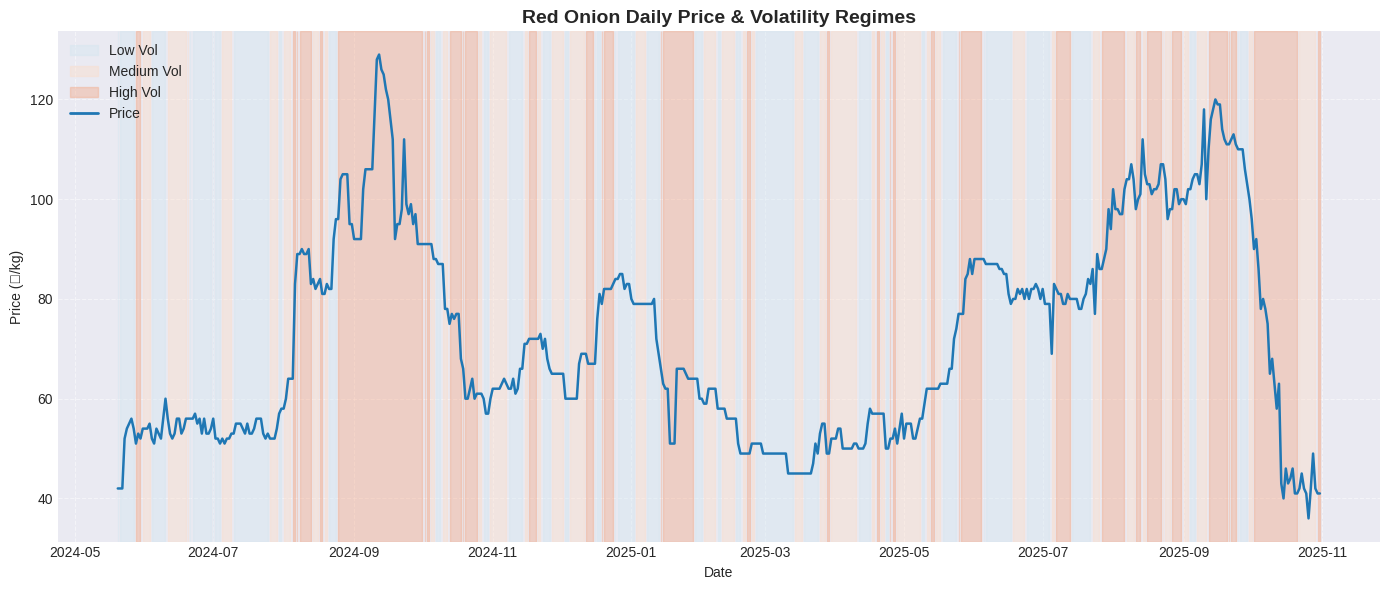

In [129]:


# Add volatility regimes
df_exog = add_volatility_regimes(df_exog, var_col="y_var7", method="quantile")

# Drop the string column (keep only numeric volatility_regime_num for LightGBM)
df_exog = df_exog.drop(columns=["volatility_regime"], errors="ignore")

# Plot
fig, ax = plot_price_with_volatility_regimes(y, df_exog, product_name="Red Onion")
plt.show()

# Save for report (PDF/png)
fig.savefig("red_onion_volatility_regimes.png", dpi=150, bbox_inches="tight")

In [130]:
regressor = LGBMRegressor(

    n_estimators=300,
    learning_rate=0.03,
    min_data_in_leaf=100,
    max_depth=20,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42

)

forecaster = ForecasterRecursive(

    regressor=regressor,
    lags=list(range(1,120)),
    differentiation=1
    
)



In [131]:
train_mask = y.index <= end_train
val_mask   = (y.index > end_train) & (y.index <= end_val)
test_mask  = (y.index > end_val)


y_train, y_val, y_test = y[train_mask], y[val_mask], y[test_mask]
X_train, X_val, X_test = df_exog[train_mask], df_exog[val_mask], df_exog[test_mask]


In [132]:
df_full = pd.concat([y.rename("target"), df_exog], axis=1)
df_full.shape


(530, 154)

In [ ]:
forecaster.fit(y_train, exog=X_train)

pred_val = forecaster.predict(len(y_val), exog=X_val)

train_val_mask = y.index <= end_val
forecaster.fit(
    y=y[train_val_mask],
    exog=df_exog[train_val_mask]
)

pred_test = forecaster.predict(len(y_test), exog=X_test)

#### forcasting on an unseen data

In [134]:

# ==============================================================================
# FEATURE ENGINEERING - INFERENCE TIME
# ==============================================================================

def build_future_features(
    y,
    exog_template,
    models,
    horizon=30
):
    """
    Build features for future time periods (inference time).
    
    This function creates features for future dates using:
    - Historical data (y) for rolling statistics
    - Fitted transformers from training (models)
    - Last known values for features that can't be computed forward
    
    IMPORTANT: This function must create features in the EXACT same order
    as build_all_features to ensure column alignment.
    
    Parameters
    ----------
    y : pd.Series
        Full historical target series with datetime index
    exog_template : pd.DataFrame
        Training features DataFrame (used to get column order and last values)
    models : dict
        Dictionary containing fitted transformers
    horizon : int
        Number of future periods to forecast
    
    Returns
    -------
    future_exog : pd.DataFrame
        Feature matrix for future dates with same columns as exog_template
    """
    cyc_encoder = models["cyc_encoder"]
    dow_mean = models["dow_mean"]
    month_mean = models["month_mean"]
    kmeans = models.get("kmeans", None)

    # 1️⃣ Create future date index
    future_dates = pd.date_range(
        start=y.index[-1] + pd.Timedelta(days=1),
        periods=horizon,
        freq='D'
    )
    idx = future_dates

    # 2️⃣ Calendar features
    cal = make_calendar_features(idx)
    cal = cyc_encoder.transform(cal)

    weekend = make_weekend_month_features(idx)

    # MULTI-YEAR holiday windows for future dates
    holidays = make_multi_year_holiday_windows(idx, window=4)

    # MULTI-YEAR holiday distance
    holiday_dist = make_holiday_distance_features(idx)


    weekend_gap = make_future_weekend_gap(y, idx)
    holiday_season = make_future_holiday_season_strength(idx)
    zscore = make_future_zscore(y, idx)
    percentile = make_future_percentile(y, idx)
    future_harvest = make_harvest_and_quarter_features(idx)
    price_rng = make_future_price_range_features(y, idx)  # Rename to match training


    # 6️⃣ Fourier signals
    fourier = fourier_features(idx)

    # 7️⃣ Rolling features (IMPORTANT: use only history!)
    roll = pd.DataFrame(index=idx)
    roll["roll7"]   = y.iloc[-7:].mean()
    roll["roll14"]  = y.iloc[-14:].mean()
    roll["roll30"]  = y.iloc[-30:].mean()
    roll["y_roll90"]  = y.iloc[-90:].mean()
    roll["y_roll180"] = y.iloc[-180:].mean()

    # 8️⃣ Diff features (based on last observed differences)
    diff = pd.DataFrame(index=idx)
    diff["y_diff1"]  = y.diff(1).iloc[-1]
    diff["y_diff7"]  = y.diff(7).iloc[-1]
    diff["y_diff14"] = y.diff(14).iloc[-1]
    diff["y_diff30"] = y.diff(30).iloc[-1]
    diff["y_diff60"] = y.diff(60).iloc[-1]
    diff["y_diff90"] = y.diff(90).iloc[-1]
 

    # 9️⃣ Volatility
    vol = pd.DataFrame(index=idx)
    vol["y_vol7"]  = y.iloc[-7:].std()
    vol["y_vol14"] = y.iloc[-14:].std()
    vol["y_vol30"] = y.iloc[-30:].std()

    # 🔟 Momentum
    mom = pd.DataFrame(index=idx)
    mom["momentum7"]  = (y.iloc[-1] - y.iloc[-7]) / y.iloc[-7]
    mom["momentum14"] = (y.iloc[-1] - y.iloc[-14]) / y.iloc[-14]
    mom["momentum30"] = (y.iloc[-1] - y.iloc[-30]) / y.iloc[-30]

    # 1️⃣1️⃣ Trend slopes — cannot recompute, so use last known slope
    slopes = pd.DataFrame(index=idx)
    slopes["trend_slope_7"]  = exog_template["trend_slope_7"].iloc[-1]
    slopes["trend_slope_30"] = exog_template["trend_slope_30"].iloc[-1]
    slopes["trend_slope_60"] = exog_template["trend_slope_60"].iloc[-1]
    slopes["trend_slope_90"] = exog_template["trend_slope_90"].iloc[-1]
    slopes["trend_slope_180"] = exog_template["trend_slope_180"].iloc[-1]

    # Variance - use last N periods from history (rename to match training)
    variance = pd.DataFrame(index=idx)
    variance["y_var7"] = y.iloc[-7:].var()
    variance["y_var14"] = y.iloc[-14:].var() if len(y) >= 14 else y.var()
    variance["y_var30"] = y.iloc[-30:].var() if len(y) >= 30 else y.var()


    garch = pd.DataFrame(index=idx)
    lag_vol = y.iloc[-7:].std()
    abs_return = y.diff(1).abs().iloc[-1]
    abs_return_yesterday = y.diff(1).abs().iloc[-2]

    garch["garch_like"] = (
        0.7 * lag_vol +
        0.2 * abs_return +
        0.1 * abs_return_yesterday
    )
    # Lagged versions for safe forecasting (only past info)
    garch["garch_like_lag1"] = garch["garch_like"].shift(1)
    garch["garch_like_lag7"] = garch["garch_like"].shift(7)

    direction = pd.DataFrame(index=idx)
    direction["dir1"] = (y.diff(1).iloc[-1] > 0).astype(int)
    direction["dir7"] = (y.diff(7).iloc[-1] > 0).astype(int)


    # Shock features - compute from history
    shock = pd.DataFrame(index=idx)
    abs_diff1 = y.diff(1).abs().iloc[-1]
    rolling_mean = y.diff(1).abs().rolling(30).mean().iloc[-1] if len(y) >= 30 else abs_diff1
    shock["abs_diff1"] = abs_diff1
    shock["shock_flag"] = (abs_diff1 > rolling_mean * 2).astype(int)

    




    # 1️⃣2️⃣ Target encoding (must use TRAINING means)
    target_enc = pd.DataFrame(index=idx)
    target_enc["dow_target"]   = idx.dayofweek.map(dow_mean).values
    target_enc["month_target"] = idx.month.map(month_mean).values

    # Combine everything (MUST MATCH build_all_features ORDER!)
    feature_list = [
        cal,
        weekend,
        holidays,
        holiday_dist,
        fourier,
        roll,
        diff,
        vol,
        mom,
        slopes,
        variance,  # Changed from var
        garch,
        direction,
        shock,  # Uncommented to match training
        target_enc,
        weekend_gap,
        holiday_season,
        zscore,
        percentile,
        future_harvest,
        price_rng  # Changed from future_price_rng
    ]
    
    future_exog = pd.concat(feature_list, axis=1)

    # Predict regimes (if kmeans available)
    if kmeans is not None:
        regime_feats = future_exog[[
            "roll7",
            "holiday_distance",
            "y_vol14",
            "y_diff7",
            "trend_slope_30",
            "momentum7"
        ]].fillna(0)
        future_exog["regime"] = kmeans.predict(regime_feats)
    else:
        # Use last known regime if kmeans not available
        future_exog["regime"] = exog_template["regime"].iloc[-1]

    # Align columns to match exog_template exactly
    future_exog = future_exog.reindex(columns=exog_template.columns).fillna(0)
    
    # Ensure numeric types only (for LightGBM)
    future_exog = future_exog.select_dtypes(include=[np.number])

    return future_exog



In [135]:
future_exog = build_future_features(
    y=y,
    exog_template=df_exog,
    models=models,
    horizon=FORECAST_HORIZON
)


In [136]:
future_exog.shape

(30, 153)

In [ ]:
forecaster.fit(y=y, exog=df_exog)

pred_future = forecaster.predict(
    steps=FORECAST_HORIZON,
    exog=future_exog
)

In [138]:
predictions_df = pd.DataFrame({
    'date': pred_future.index,
    'predicted_price': pred_future.values
})

### metrics

In [156]:
# ==============================================================================
# EVALUATION METRICS AND VISUALIZATION
# ==============================================================================

def compute_metrics(actual, predicted, name=""):
    """
    Compute comprehensive forecasting metrics.
    
    Parameters
    ----------
    actual : array-like
        Actual values
    predicted : array-like
        Predicted values
    name : str
        Name for the metric set (e.g., "Validation", "Test")
    
    Returns
    -------
    dict with metrics: MAE, MAPE, RMSE, R²
    """
    from sklearn.metrics import r2_score
    
    mae = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted)
    # Calculate RMSE manually (sqrt of MSE) for compatibility
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)
    
    metrics = {
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse,
        'R2': r2
    }
    
    print(f"\n{'='*50}")
    print(f"{name.upper()} METRICS")
    print(f"{'='*50}")
    print(f"MAE  : {mae:.4f}")
    print(f"MAPE : {mape*100:.2f}%")
    print(f"RMSE : {rmse:.4f}")
    print(f"R²   : {r2:.4f}")
    print(f"{'='*50}\n")
    
    return metrics


def plot_forecast_comparison(y_true, y_pred, title="Forecast Comparison", figsize=(14, 6)):
    """
    Plot actual vs predicted values with improved styling.
    
    Parameters
    ----------
    y_true : pd.Series
        Actual values with datetime index
    y_pred : pd.Series
        Predicted values with datetime index
    title : str
        Plot title
    figsize : tuple
        Figure size
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    ax.plot(y_true.index, y_true.values, label='Actual', linewidth=2, color='#2E86AB', alpha=0.8)
    ax.plot(y_pred.index, y_pred.values, label='Predicted', linewidth=2, color='#A23B72', linestyle='--', alpha=0.8)
    
    ax.fill_between(y_true.index, y_true.values, y_pred.values, alpha=0.2, color='gray', label='Error')
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price (₹/kg)', fontsize=12)
    ax.legend(loc='best', fontsize=11)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    return fig, ax


def plot_residuals_analysis(y_true, y_pred, title="Residuals Analysis", figsize=(14, 10)):
    """
    Create comprehensive residuals analysis plot.
    
    Parameters
    ----------
    y_true : pd.Series
        Actual values
    y_pred : pd.Series
        Predicted values
    title : str
        Plot title
    figsize : tuple
        Figure size
    """
    residuals = y_true - y_pred
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Time series of residuals
    axes[0, 0].plot(residuals.index, residuals.values, alpha=0.7)
    axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[0, 0].set_title('Residuals Over Time', fontweight='bold')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Residual')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Histogram of residuals
    axes[0, 1].hist(residuals.values, bins=30, edgecolor='black', alpha=0.7)
    axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[0, 1].set_title('Distribution of Residuals', fontweight='bold')
    axes[0, 1].set_xlabel('Residual')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Q-Q plot
    from scipy import stats
    stats.probplot(residuals.values, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Residuals vs Predicted
    axes[1, 1].scatter(y_pred.values, residuals.values, alpha=0.5)
    axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[1, 1].set_title('Residuals vs Predicted', fontweight='bold')
    axes[1, 1].set_xlabel('Predicted')
    axes[1, 1].set_ylabel('Residual')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig, axes


def plot_feature_importance(forecaster, top_n=15, figsize=(12, 8)):
    """
    Plot top N feature importances from a trained forecaster.
    
    Parameters
    ----------
    forecaster : ForecasterRecursive
        Trained forecaster with feature importance method
    top_n : int
        Number of top features to display (default: 15)
    figsize : tuple
        Figure size
    
    Returns
    -------
    fig, ax : matplotlib figure and axes
    importance_df : pd.DataFrame
        DataFrame with feature importances sorted by importance
    """
    # Get feature importance
    importance = forecaster.get_feature_importances()
    
    # Sort by importance (descending)
    importance_sorted = importance.sort_values(by='importance', ascending=False)
    
    # Get top N features
    top_features = importance_sorted.head(top_n)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create horizontal bar plot
    colors = plt.cm.viridis(np.linspace(0, 1, top_n))
    bars = ax.barh(range(top_n), top_features['importance'].values, color=colors)
    
    # Customize plot
    ax.set_yticks(range(top_n))
    ax.set_yticklabels(top_features['feature'].values, fontsize=10)
    ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
    ax.set_title(f'Top {top_n} Feature Importances', fontsize=14, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, axis='x', linestyle='--')
    
    # Add value labels on bars
    for i, (idx, row) in enumerate(top_features.iterrows()):
        value = row['importance']
        ax.text(value + max(top_features['importance']) * 0.01, i, 
                f'{value:.4f}', va='center', fontsize=9)
    
    # Invert y-axis to show highest importance at top
    ax.invert_yaxis()
    
    # Add percentage of total importance
    total_importance = importance_sorted['importance'].sum()
    top_total = top_features['importance'].sum()
    percentage = (top_total / total_importance) * 100
    
    ax.text(0.98, 0.02, f'Top {top_n} features account for {percentage:.1f}% of total importance',
            transform=ax.transAxes, fontsize=10, ha='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    
    return fig, ax, importance_sorted


def plot_out_of_sample_forecast(y_actual, y_pred, title="Out-of-Sample Forecast", 
                                 show_metrics=True, show_residuals=True, figsize=(16, 10)):
    """
    Create a comprehensive out-of-sample forecast visualization.
    
    Parameters
    ----------
    y_actual : pd.Series or array-like
        Actual values with datetime index
    y_pred : pd.Series or array-like
        Predicted values with datetime index
    title : str
        Plot title
    show_metrics : bool
        Whether to display metrics on the plot
    show_residuals : bool
        Whether to include residuals subplot
    figsize : tuple
        Figure size
    
    Returns
    -------
    fig : matplotlib figure
    metrics_dict : dict
        Dictionary with computed metrics
    """
    # Convert to Series if needed
    if not isinstance(y_actual, pd.Series):
        y_actual = pd.Series(y_actual)
    if not isinstance(y_pred, pd.Series):
        y_pred = pd.Series(y_pred)
    
    # Ensure same index
    common_idx = y_actual.index.intersection(y_pred.index)
    y_actual = y_actual.loc[common_idx]
    y_pred = y_pred.loc[common_idx]
    
    # Calculate metrics
    mae = mean_absolute_error(y_actual, y_pred)
    mape = mean_absolute_percentage_error(y_actual, y_pred)
    mse = mean_squared_error(y_actual, y_pred)
    rmse = np.sqrt(mse)
    from sklearn.metrics import r2_score
    r2 = r2_score(y_actual, y_pred)
    
    metrics_dict = {
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse,
        'R2': r2
    }
    
    # Calculate residuals
    residuals = y_actual - y_pred
    
    # Determine number of subplots
    n_subplots = 2 if show_residuals else 1
    fig, axes = plt.subplots(n_subplots, 1, figsize=figsize, 
                             gridspec_kw={'height_ratios': [3, 1] if show_residuals else [1]})
    
    if not show_residuals:
        axes = [axes]
    
    # Main forecast plot
    ax1 = axes[0]
    
    # Plot actual and predicted
    ax1.plot(y_actual.index, y_actual.values, 
             label='Actual', linewidth=2.5, color='#2E86AB', marker='o', markersize=6, alpha=0.9)
    ax1.plot(y_pred.index, y_pred.values, 
             label='Predicted', linewidth=2.5, color='#A23B72', marker='s', markersize=6, 
             linestyle='--', alpha=0.9)
    
    # Fill area between actual and predicted
    ax1.fill_between(y_actual.index, y_actual.values, y_pred.values, 
                     alpha=0.2, color='gray', label='Error')
    
    # Customize main plot
    ax1.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Price (₹/kg)', fontsize=12, fontweight='bold')
    ax1.legend(loc='best', fontsize=11, framealpha=0.9)
    ax1.grid(True, alpha=0.3, linestyle='--')
    
    # Add metrics text box
    if show_metrics:
        metrics_text = f'MAE: {mae:.2f}  |  MAPE: {mape*100:.2f}%  |  RMSE: {rmse:.2f}  |  R²: {r2:.4f}'
        ax1.text(0.5, 0.98, metrics_text, transform=ax1.transAxes,
                fontsize=11, ha='center', va='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Residuals subplot
    if show_residuals:
        ax2 = axes[1]
        ax2.plot(residuals.index, residuals.values, 
                color='#F18F01', linewidth=1.5, marker='o', markersize=4, alpha=0.7)
        ax2.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.8)
        ax2.fill_between(residuals.index, residuals.values, 0, 
                         alpha=0.3, color='#F18F01', where=(residuals.values >= 0))
        ax2.fill_between(residuals.index, residuals.values, 0, 
                         alpha=0.3, color='#C73E1D', where=(residuals.values < 0))
        
        ax2.set_title('Residuals (Actual - Predicted)', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Date', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Residual', fontsize=11, fontweight='bold')
        ax2.grid(True, alpha=0.3, linestyle='--')
        
        # Add mean absolute residual line
        mean_abs_residual = residuals.abs().mean()
        ax2.axhline(y=mean_abs_residual, color='blue', linestyle=':', linewidth=1.5, 
                   alpha=0.6, label=f'Mean |Residual|: {mean_abs_residual:.2f}')
        ax2.axhline(y=-mean_abs_residual, color='blue', linestyle=':', linewidth=1.5, alpha=0.6)
        ax2.legend(loc='best', fontsize=9)
    
    plt.tight_layout()
    
    return fig, metrics_dict


In [146]:
compute_metrics(y_val, pred_val, "Validation")
compute_metrics(y_test, pred_test, "Test")


VALIDATION METRICS
MAE  : 4.1758
MAPE : 4.05%
RMSE : 4.8344
R²   : 0.4044


TEST METRICS
MAE  : 16.1621
MAPE : 35.16%
RMSE : 17.9808
R²   : 0.0533



{'MAE': 16.16212827728238,
 'MAPE': 0.35163021525268323,
 'RMSE': np.float64(17.98078841445407),
 'R2': 0.05329318176313558}

## plots

In [147]:

actual_oos = out_of_sample_df.copy()
pred_oos   = predictions_df.copy()

actual_oos.index = pd.to_datetime(actual_oos.index)
pred_oos.index   = pd.to_datetime(pred_oos.index)
out_of_sample_start = pd.to_datetime("2025-11-01")


pred_oos.index = pd.date_range(
    start=out_of_sample_start,
    periods=len(pred_oos),
    freq="D"
)

actual_oos.index = pd.date_range(
    start=out_of_sample_start,
    periods=len(actual_oos),
    freq="D"
)


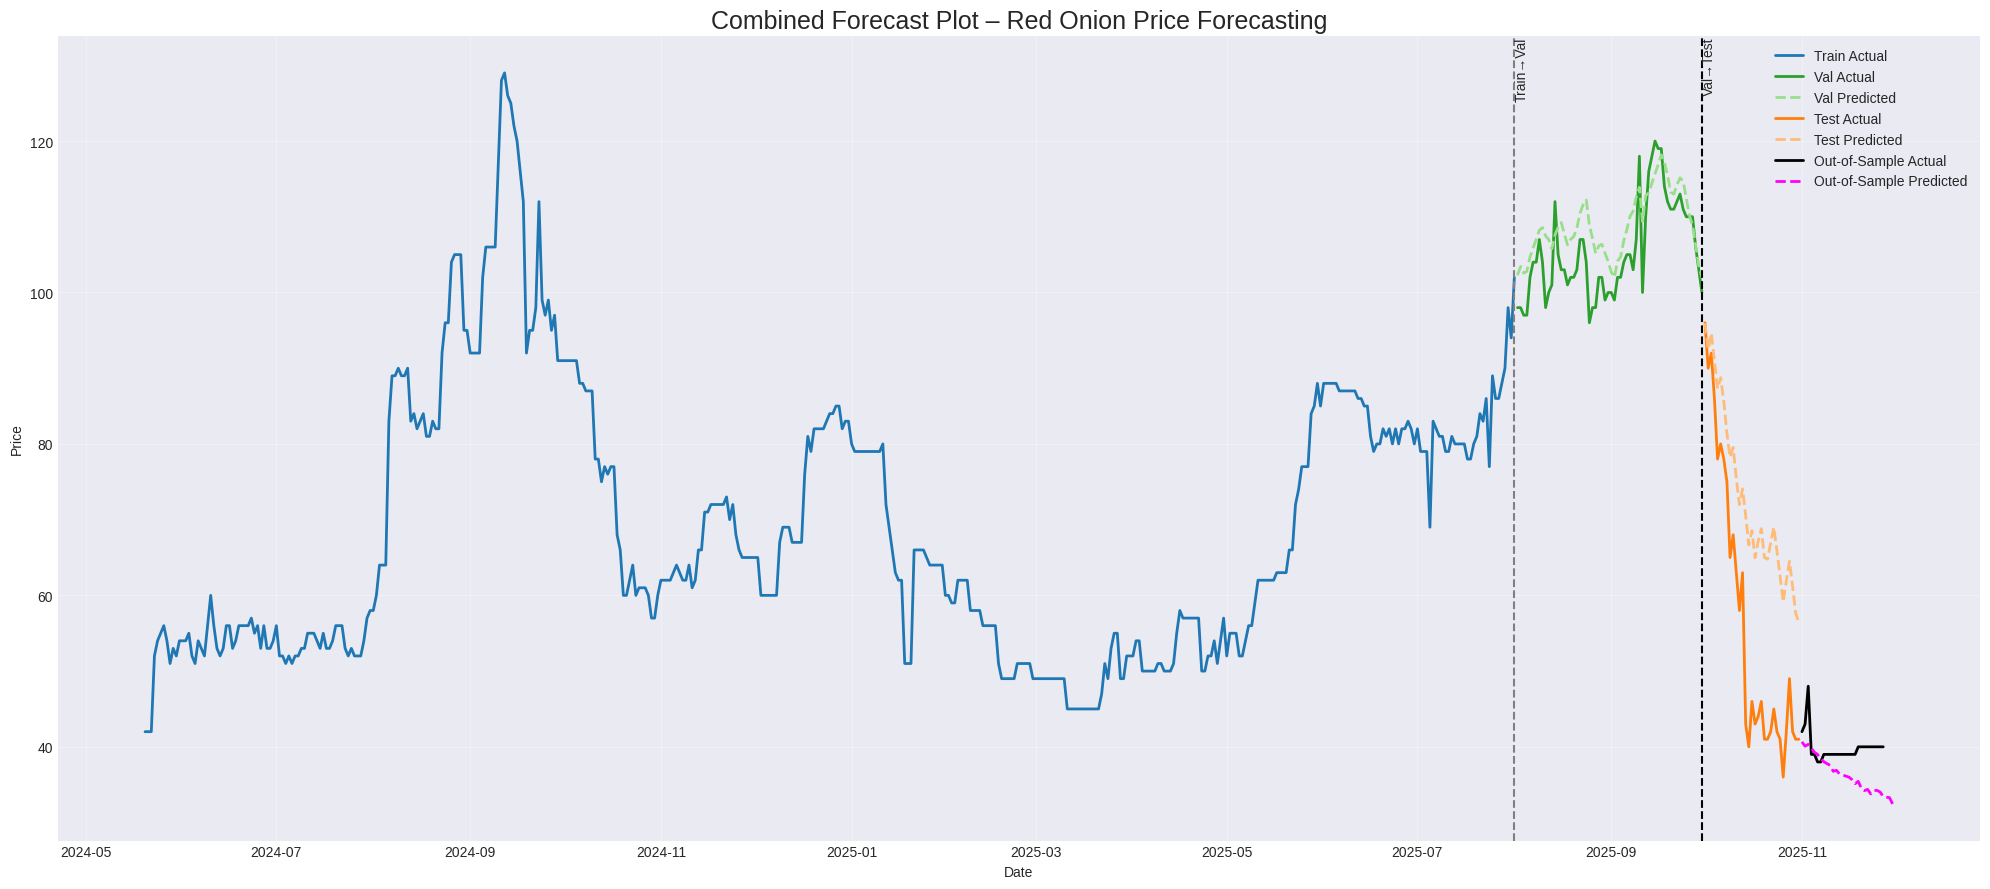

In [148]:
# ============================================================
# COMBINED PLOT: Train + Val + Test + Out-of-Sample (Clean + Clear Colors)
# ============================================================

plt.figure(figsize=(20, 9))

# ------------------ TRAIN ------------------
plt.plot(
    y_train.index, y_train.values,
    label="Train Actual",
    linewidth=2, color="#1f77b4"   # Blue
)

# ------------------ VALIDATION ------------------
plt.plot(
    y_val.index, y_val.values,
    label="Val Actual",
    linewidth=2, color="#2ca02c"   # Green
)
plt.plot(
    pred_val.index, pred_val.values,
    label="Val Predicted",
    linewidth=2, linestyle="--", color="#98df8a"
)

# ------------------ TEST ------------------
plt.plot(
    y_test.index, y_test.values,
    label="Test Actual",
    linewidth=2, color="#ff7f0e"   # Orange
)
plt.plot(
    pred_test.index, pred_test.values,
    label="Test Predicted",
    linewidth=2, linestyle="--", color="#ffbb78"
)

# ------------------ OUT-OF-SAMPLE ------------------
plt.plot(
    actual_oos.index, actual_oos["price"],
    label="Out-of-Sample Actual",
    linewidth=2, color="black"
)
plt.plot(
    pred_oos.index, pred_oos["predicted_price"],
    label="Out-of-Sample Predicted",
    linewidth=2, linestyle="--", color="magenta"
)

# ------------------ SPLIT LINES ------------------
plt.axvline(x=end_train, color="gray", linestyle="--", linewidth=1.5)
plt.axvline(x=end_val, color="black", linestyle="--", linewidth=1.5)

plt.text(end_train, plt.ylim()[1], "Train→Val", rotation=90, va='top')
plt.text(end_val, plt.ylim()[1], "Val→Test", rotation=90, va='top')

# ------------------ STYLE ------------------
plt.title("Combined Forecast Plot – Red Onion Price Forecasting", fontsize=18)
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


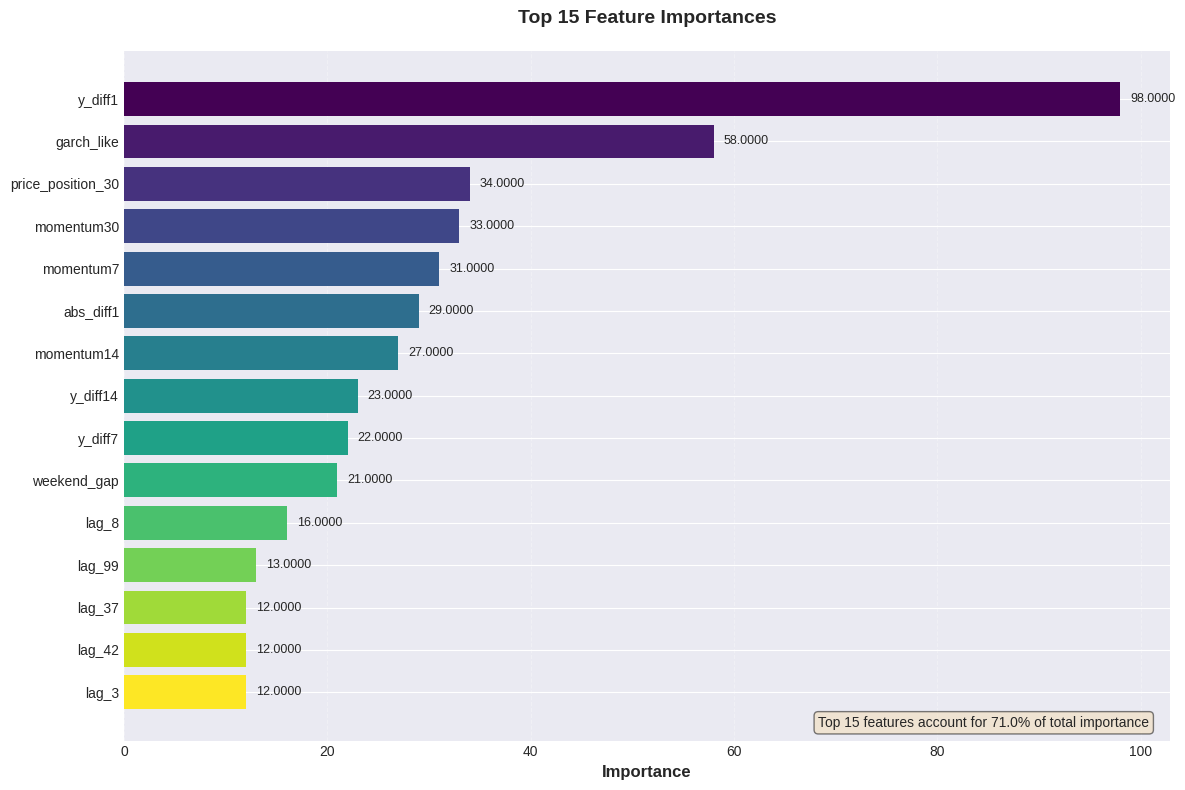


Top 15 Most Important Features:
          feature  importance
          y_diff1          98
       garch_like          58
price_position_30          34
       momentum30          33
        momentum7          31
        abs_diff1          29
       momentum14          27
         y_diff14          23
          y_diff7          22
      weekend_gap          21
            lag_8          16
           lag_99          13
           lag_37          12
           lag_42          12
            lag_3          12


In [153]:
# ==============================================================================
# FEATURE IMPORTANCE VISUALIZATION
# ==============================================================================

# Get feature importance and create visualization
fig, ax, importance_df = plot_feature_importance(forecaster, top_n=15)
plt.show()

# Display top 15 features as DataFrame
print("\nTop 15 Most Important Features:")
print("=" * 60)
print(importance_df.head(15).to_string(index=False))
print("=" * 60)


### only out-of-sample

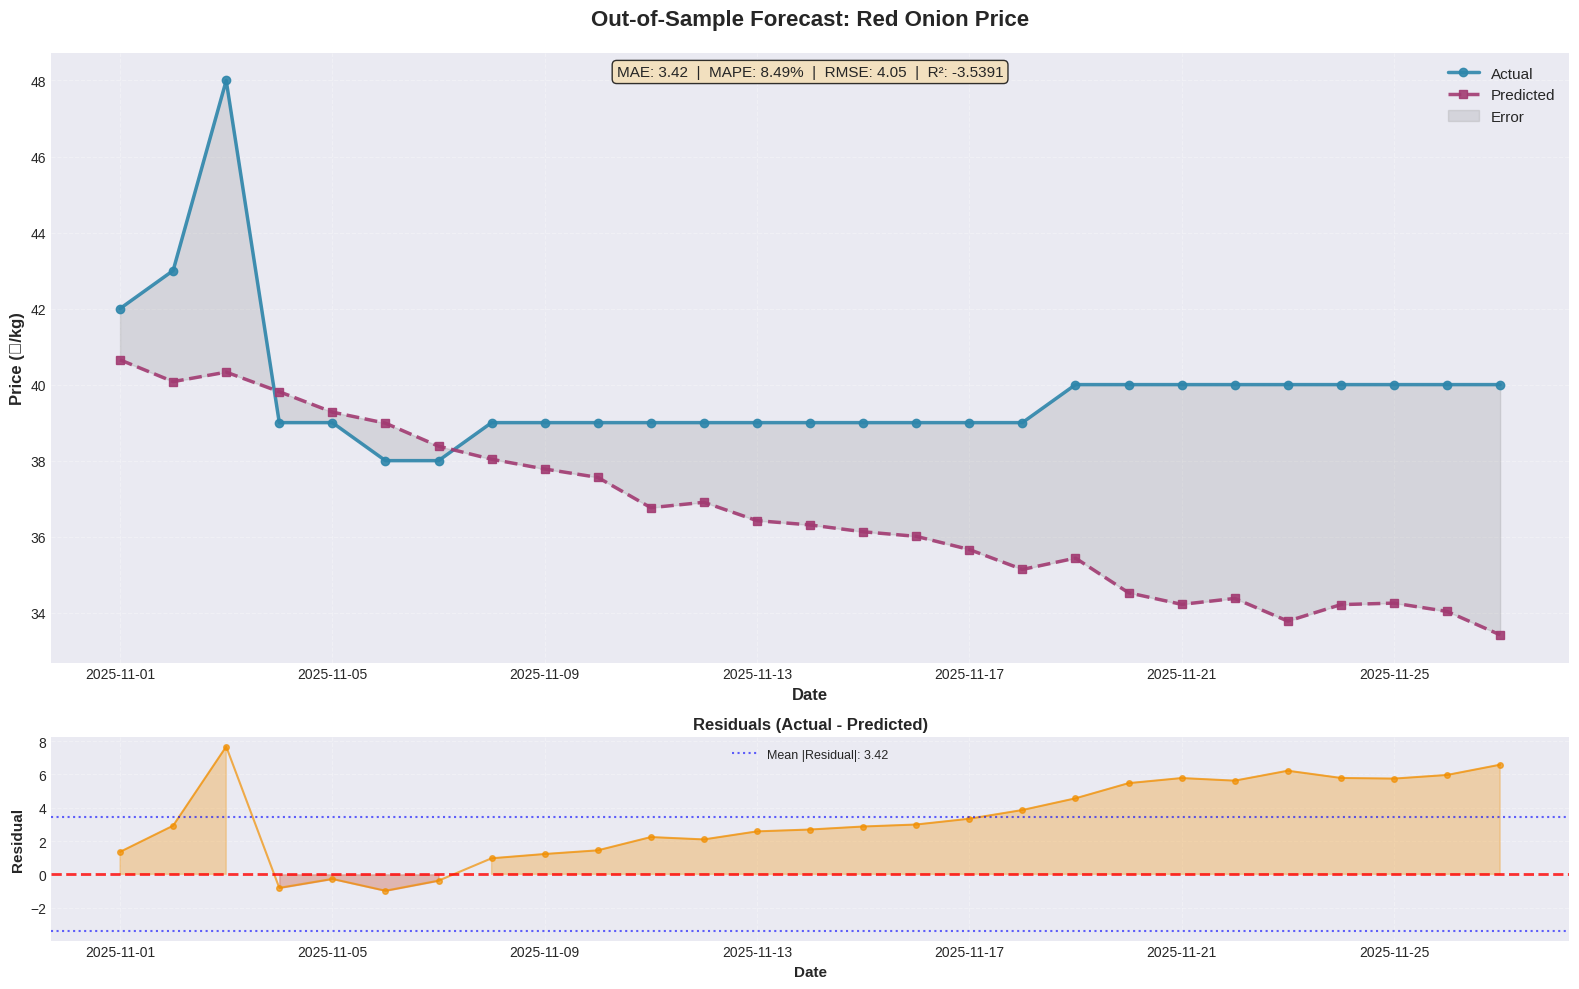


OUT-OF-SAMPLE FORECAST METRICS
MAE     :   3.4237
MAPE    :     8.49%
RMSE    :   4.0467
R2      :  -3.5391



In [157]:
# ==============================================================================
# OUT-OF-SAMPLE FORECAST VISUALIZATION
# ==============================================================================

# Prepare data
pred = predictions_df.copy()
actual = out_of_sample_df.copy()

pred['date'] = pd.to_datetime(pred['date'])
actual['date'] = pd.to_datetime(actual['date'])

pred = pred.set_index('date')
actual = actual.set_index('date')

# Create comprehensive visualization
fig, metrics = plot_out_of_sample_forecast(
    y_actual=actual['price'],
    y_pred=pred['predicted_price'],
    title="Out-of-Sample Forecast: Red Onion Price",
    show_metrics=True,
    show_residuals=True,
    figsize=(16, 10)
)
plt.show()

# Print metrics summary
print("\n" + "="*60)
print("OUT-OF-SAMPLE FORECAST METRICS")
print("="*60)
for metric, value in metrics.items():
    if metric == 'MAPE':
        print(f"{metric:8s}: {value*100:8.2f}%")
    else:
        print(f"{metric:8s}: {value:8.4f}")
print("="*60 + "\n")
